# Regresión Lineal

## 1. Librerias y configuraciones previas


In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Creación de modelo
import statsmodels.api as sm
#from sklearn.linear_model import LinearRegression


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [ ]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from funciones import multiple_plot, plot_roc_curve, tidy_corr_matrix, checkVIF

In [ ]:
# Función para contruir un modelo de regresión lineal por medio de statsmodels.api

def build_model(X,y):

    #A los datos de entrada 'X' se le adiciona una constante
    X = sm.add_constant(X)

    #Se crea y se entrena el modelo de regresion lineal q(statsmodels.api) con
    #los datos de entrada 'X' y los datos de salida 'y'
    lm = sm.OLS(y,X).fit()

    #imprime el resumen del modelo creado
    print(lm.summary()) # model summary

    return X

## 3. Carga del dataset

In [ ]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('/content/gemstone_Prep.csv')
df=d.copy()

In [ ]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive
#import os

#drive.mount('/gdrive')

In [ ]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20375 entries, 0 to 20374
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    20375 non-null  float64
 1   depth    20375 non-null  float64
 2   table    20375 non-null  float64
 3   x        20375 non-null  float64
 4   y        20375 non-null  float64
 5   z        20375 non-null  float64
 6   price    20375 non-null  float64
 7   cut      20375 non-null  object 
 8   color    20375 non-null  object 
 9   clarity  20375 non-null  object 
dtypes: float64(7), object(3)
memory usage: 1.6+ MB


## 4. Visualización de datos

### Variables de entrada

In [ ]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,cut,color,clarity
0,Very Good,H,SI1
1,Ideal,G,SI2


In [ ]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head(2)

,carat,depth,table,x,y,z,price
0,0.72,63.7,57.0,5.66,5.70,3.62,2168.0
1,1.16,61.3,55.0,6.79,6.84,4.18,4425.0


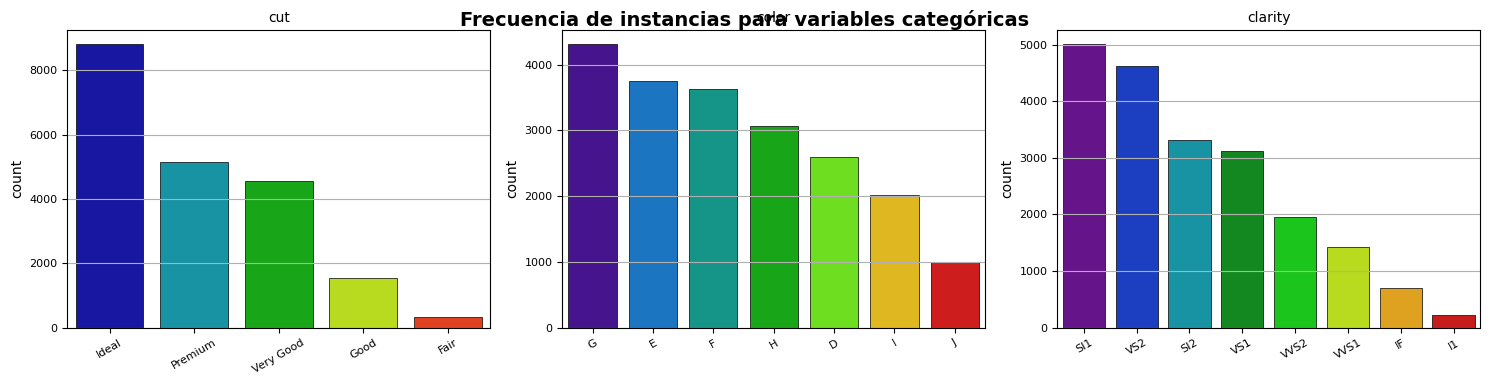

In [ ]:
##Visualización de frecuencia de instancias para variables categóricas
multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [ ]:
#Visualización por medio de gráficos de caja de bigotes para las variables categóricas con respecto al precio
#multiple_plot(3, d , catCols, 'Price', 'boxplot', 'Distribución de la variable Make vs. el Price',30)

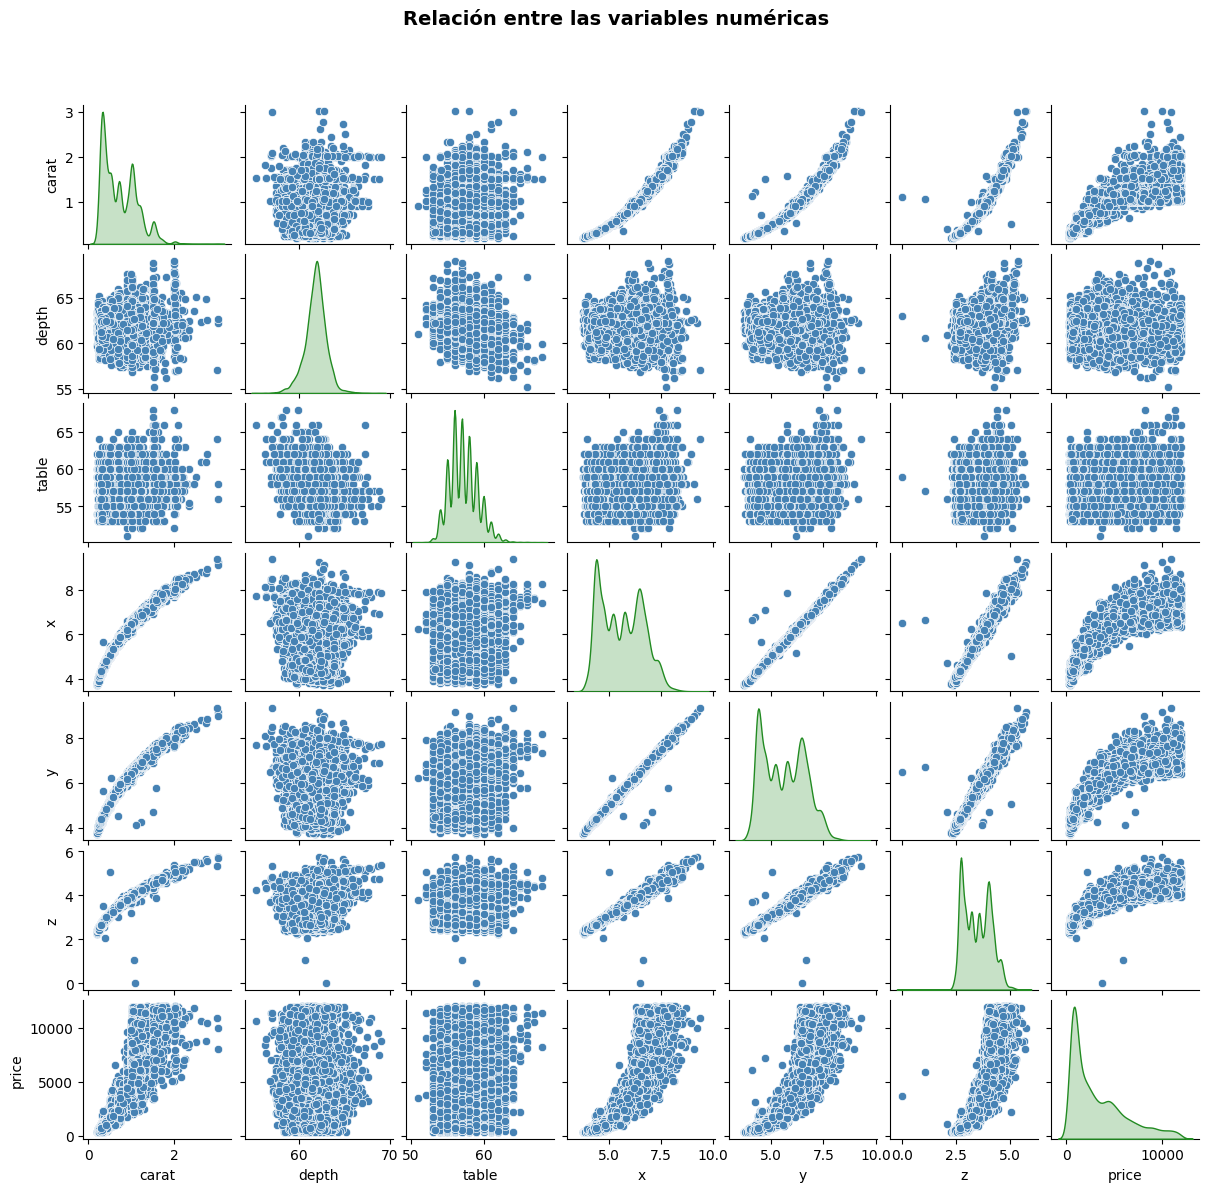

In [ ]:
#Visualización de variables numéricas con respecto al precio
multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [ ]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('price')

### Variable de salida

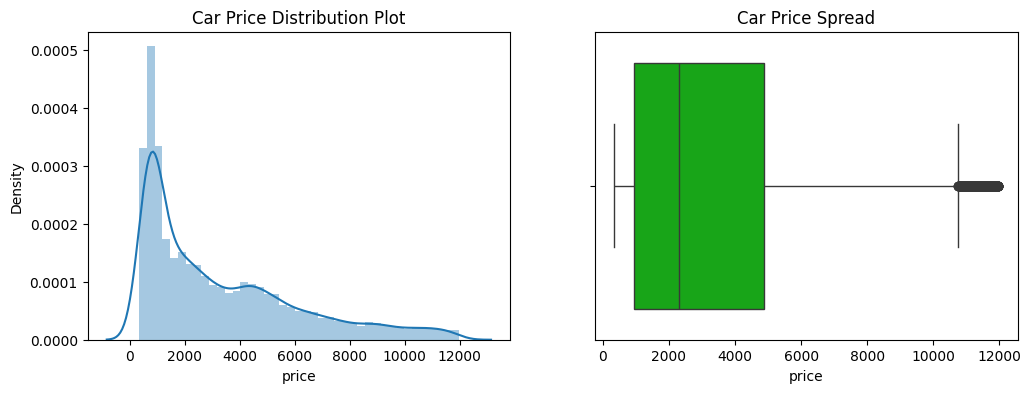

In [ ]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(d.price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=d.price, palette='nipy_spectral')

plt.show()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   20375
mean     3288
std      2837
min       337
25%       932
50%      2313
75%      4864
85%      6416
90%      7640
95%      9432
97.5%   10640
100%    11971
max     11971
Name: price, dtype: float64


## 6. Preparación de datos

### Transformaciones para la variable de salida

In [ ]:
#Tranformacion y = y^(1/3) Raiz cúbica

d['price'] = np.cbrt(d['price'])

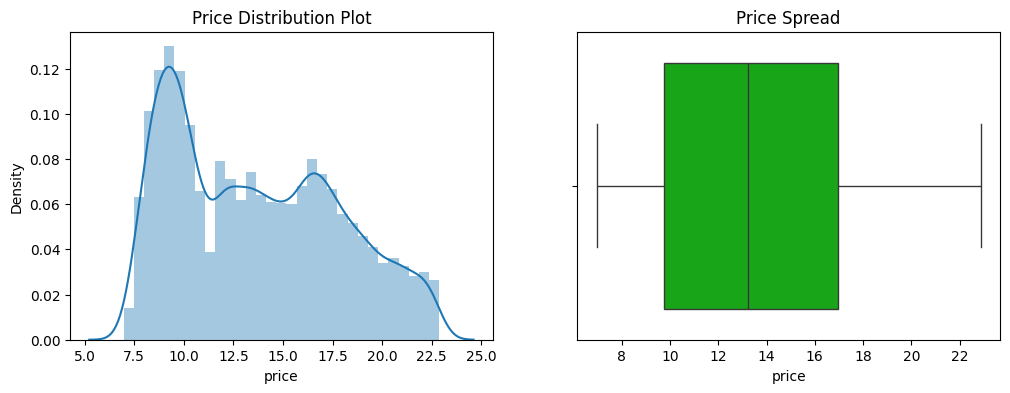

In [ ]:
#Histográma y caja de bigotes del precio de los vehículos transformado

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Price Distribution Plot')
sns.distplot(d.price)

plt.subplot(1,2,2)
plt.title('Price Spread')
sns.boxplot(x=d.price, palette='nipy_spectral')

plt.show()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   20375
mean       14
std         4
min         7
25%        10
50%        13
75%        17
85%        19
90%        20
95%        21
97.5%      22
100%       23
max        23
Name: price, dtype: float64


### Transformaciones a las variables de entrada

### Correlaciones

In [ ]:
# Generación de la matriz de correlación
matrizCorr = d.corr(numeric_only=True)

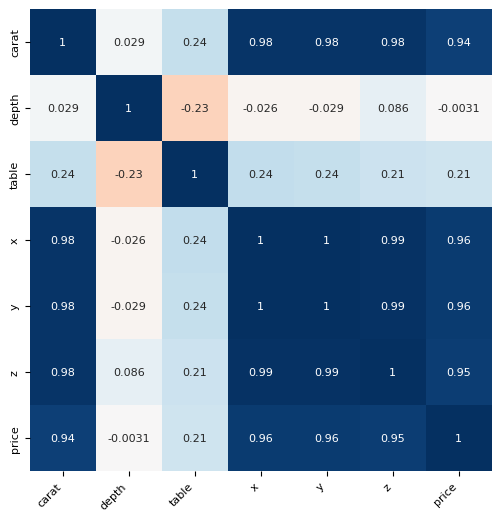

In [ ]:
# Mapa de calor (Heatmap) de la matriz de correlaciones

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)


ax.tick_params(labelsize = 8)


In [ ]:
#Matriz de correlación ordenada

pd.set_option('display.float_format', lambda x: '%.4f' % x)

#Creación de la matriz
df_corr= tidy_corr_matrix(matrizCorr)

#Selección de las variables correlacionadas con el precio
df_filtrado = df_corr.loc[df_corr['variable_2'] == 'price']

#Se identifican las correlaciones más fuertes
df_filtrado[df_filtrado['abs_r']>=0.5]

,variable_1,variable_2,r,abs_r
34,y,price,0.9566,0.9566
27,x,price,0.9561,0.9561
41,z,price,0.9513,0.9513
6,carat,price,0.9423,0.9423


In [ ]:
#Cantidad de variables más relevantes extraidas a partir de la matriz de correlación ordenada
VarRelevantes = df_filtrado[df_filtrado['abs_r']>=0.5].shape[0]

#Creacion de la lista de variables más relevantes (inicialmente numéricas)
vDep =df_filtrado['variable_1'][:VarRelevantes].tolist()
print(vDep)

['y', 'x', 'z', 'carat']


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20375 entries, 0 to 20374
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    20375 non-null  float64
 1   depth    20375 non-null  float64
 2   table    20375 non-null  float64
 3   x        20375 non-null  float64
 4   y        20375 non-null  float64
 5   z        20375 non-null  float64
 6   price    20375 non-null  float64
 7   cut      20375 non-null  object 
 8   color    20375 non-null  object 
 9   clarity  20375 non-null  object 
dtypes: float64(7), object(3)
memory usage: 1.6+ MB


In [ ]:
d.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'price', 'cut', 'color',
       'clarity'],
      dtype='object')

In [ ]:
# Se adiiona a la lista de variables numericas más relevantes todas las variables categóricas
vDep += catCols

vDep

['y', 'x', 'z', 'carat', 'cut', 'color', 'clarity']

In [ ]:
d = d[vDep  +['price']]

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20375 entries, 0 to 20374
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   y        20375 non-null  float64
 1   x        20375 non-null  float64
 2   z        20375 non-null  float64
 3   carat    20375 non-null  float64
 4   cut      20375 non-null  object 
 5   color    20375 non-null  object 
 6   clarity  20375 non-null  object 
 7   price    20375 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.2+ MB


### Creación de Variables Dummies

In [ ]:
# Aplicación de la función de get_dummies

d =pd.get_dummies(d, drop_first=1)

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20375 entries, 0 to 20374
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              20375 non-null  float64
 1   x              20375 non-null  float64
 2   z              20375 non-null  float64
 3   carat          20375 non-null  float64
 4   price          20375 non-null  float64
 5   cut_Good       20375 non-null  bool   
 6   cut_Ideal      20375 non-null  bool   
 7   cut_Premium    20375 non-null  bool   
 8   cut_Very Good  20375 non-null  bool   
 9   color_E        20375 non-null  bool   
 10  color_F        20375 non-null  bool   
 11  color_G        20375 non-null  bool   
 12  color_H        20375 non-null  bool   
 13  color_I        20375 non-null  bool   
 14  color_J        20375 non-null  bool   
 15  clarity_IF     20375 non-null  bool   
 16  clarity_SI1    20375 non-null  bool   
 17  clarity_SI2    20375 non-null  bool   
 18  clarit

In [ ]:
# Obtener una lista de columnas que son de tipo bool
bool_columns = d.select_dtypes(include='bool').columns

# Convertir las columnas bool a int8
d[bool_columns] = d[bool_columns].astype('uint8')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20375 entries, 0 to 20374
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              20375 non-null  float64
 1   x              20375 non-null  float64
 2   z              20375 non-null  float64
 3   carat          20375 non-null  float64
 4   price          20375 non-null  float64
 5   cut_Good       20375 non-null  uint8  
 6   cut_Ideal      20375 non-null  uint8  
 7   cut_Premium    20375 non-null  uint8  
 8   cut_Very Good  20375 non-null  uint8  
 9   color_E        20375 non-null  uint8  
 10  color_F        20375 non-null  uint8  
 11  color_G        20375 non-null  uint8  
 12  color_H        20375 non-null  uint8  
 13  color_I        20375 non-null  uint8  
 14  color_J        20375 non-null  uint8  
 15  clarity_IF     20375 non-null  uint8  
 16  clarity_SI1    20375 non-null  uint8  
 17  clarity_SI2    20375 non-null  uint8  
 18  clarit

## 7. Creación del modelo

### Dividir el conjunto de datos

In [ ]:
#Se crea un dataframe de prueba de un 10% de los datos
#dPrueba = d.sample(frac=0.1, random_state=321)

#se eliminan los datos de prueba del dataframe
#d = d.drop(index=dPrueba.index)

In [ ]:
#Se crea una lista con todas las varibles de entrada

vDep = list(d.columns)
vDep.remove('price')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='price')
y = d['price']

In [ ]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo.

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
#Se establecen las variables numéricas a escalar

#Num_vars contiene la intersección de variables de las listas numCols y vDep
num_vars = list(set(numCols) & set(vDep))

print(num_vars)

['z', 'y', 'x', 'carat']


### Escalar Variables

In [ ]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head()

,z,y,x,carat
14700,0.5620,0.2804,0.2642,0.1210
11363,0.7574,0.5643,0.5479,0.3737
2105,0.6736,0.4304,0.4167,0.2491
1996,0.6771,0.5018,0.4858,0.2847
9544,0.7260,0.5339,0.5142,0.3345


In [ ]:
X_train.head(2)

,y,x,z,carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
14700,0.2804,0.2642,0.5620,0.1210,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
11363,0.5643,0.5479,0.7574,0.3737,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


### Creación del modelo

In [ ]:
#Llamamos la funcion build_model definida al principio de este notebook que crea y entrena el modelo

modelo_X_train = build_model(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 2.660e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        15:15:32   Log-Likelihood:                -17472.
No. Observations:               16300   AIC:                         3.499e+04
Df Residuals:                   16278   BIC:                         3.516e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.4715      0.195    -12.675

Es poco común (aunque posible) que todos los coeficientes tengan valores p iguales a cero, ya que esto sugeriría que todas las variables independientes están contribuyendo de manera significativa al modelo. Esto puede ocurrir en casos muy específicos, como tener un número muy pequeño de observaciones en comparación con el número de variables, lo que puede conducir a un sobreajuste, por lo cual Consideraremos  la multicolinealidad: Si tienes multicolinealidad entre las variables independientes, esto puede hacer que los coeficientes estimados sean poco confiables.



### Colinealidad

In [ ]:
#Se aplica la funcion de Factor de Inflación de la Varianza (VIF- Variance Inflation Factor) para identificar colinealidad
#entre las variables

checkVIF(modelo_X_train)

,Features,VIF
0,const,1238.9300
2,x,410.5400
1,y,359.8000
3,z,66.7100
4,carat,35.5300
6,cut_Ideal,18.1400
16,clarity_SI1,17.1200
19,clarity_VS2,16.4300
7,cut_Premium,14.1300
8,cut_Very Good,13.1200


In [ ]:
#Se elimina la variable 'Engine'
modelo_X_train = modelo_X_train.drop(["x"], axis = 1)


In [ ]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 2.754e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        15:15:33   Log-Likelihood:                -17581.
No. Observations:               16300   AIC:                         3.520e+04
Df Residuals:                   16279   BIC:                         3.537e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.0621      0.192    -15.936

In [ ]:
#Se aplica la funcion de Factor de Inflación de la Varianza (VIF- Variance Inflation Factor) para identificar colinealidad
#entre las variables

checkVIF(modelo_X_train)

,Features,VIF
0,const,1187.1900
1,y,67.4100
2,z,62.8000
3,carat,34.2100
5,cut_Ideal,18.1300
15,clarity_SI1,17.1200
18,clarity_VS2,16.4300
6,cut_Premium,14.0700
7,cut_Very Good,13.0400
16,clarity_SI2,12.7400


In [ ]:
#Se elimina la variable 'Engine'
modelo_X_train = modelo_X_train.drop(["y"], axis = 1)

In [ ]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 2.464e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        15:15:34   Log-Likelihood:                -18867.
No. Observations:               16300   AIC:                         3.777e+04
Df Residuals:                   16280   BIC:                         3.793e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -9.8659      0.154    -64.020

In [ ]:
#Se aplica la funcion de Factor de Inflación de la Varianza (VIF- Variance Inflation Factor) para identificar colinealidad
#entre las variables

checkVIF(modelo_X_train)

,Features,VIF
0,const,652.2100
2,carat,28.5300
1,z,28.3200
14,clarity_SI1,17.0500
4,cut_Ideal,16.7600
17,clarity_VS2,16.3700
5,cut_Premium,13.0100
15,clarity_SI2,12.6900
16,clarity_VS1,12.3700
6,cut_Very Good,12.1300


In [ ]:
#Se elimina la variable 'Engine'
modelo_X_train = modelo_X_train.drop(["carat"], axis = 1)

In [ ]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 2.272e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        15:15:35   Log-Likelihood:                -19928.
No. Observations:               16300   AIC:                         3.989e+04
Df Residuals:                   16281   BIC:                         4.004e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -15.8810      0.094   -168.903

In [ ]:
#Se aplica la funcion de Factor de Inflación de la Varianza (VIF- Variance Inflation Factor) para identificar colinealidad
#entre las variables

checkVIF(modelo_X_train)

,Features,VIF
0,const,213.1700
13,clarity_SI1,16.7500
3,cut_Ideal,16.7400
16,clarity_VS2,16.1200
4,cut_Premium,12.9300
14,clarity_SI2,12.5400
15,clarity_VS1,12.2000
5,cut_Very Good,12.1100
18,clarity_VVS2,8.5100
17,clarity_VVS1,6.8000


In [ ]:
#Se elimina la variable 'Engine'
modelo_X_train = modelo_X_train.drop(["clarity_SI1"], axis = 1)

In [ ]:
#Se aplica la funcion de Factor de Inflación de la Varianza (VIF- Variance Inflation Factor) para identificar colinealidad
#entre las variables

checkVIF(modelo_X_train)

,Features,VIF
0,const,125.3800
3,cut_Ideal,16.6900
4,cut_Premium,12.9000
5,cut_Very Good,12.0700
2,cut_Good,5.4500
8,color_G,2.1800
6,color_E,2.0000
7,color_F,1.9900
9,color_H,1.9100
10,color_I,1.6700


In [ ]:

#Se elimina la variable 'Engine'
modelo_X_train = modelo_X_train.drop(["cut_Ideal"], axis = 1)

In [ ]:
#Se aplica la funcion de Factor de Inflación de la Varianza (VIF- Variance Inflation Factor) para identificar colinealidad
#entre las variables

checkVIF(modelo_X_train)

,Features,VIF
0,const,48.9100
7,color_G,2.1800
5,color_E,2.0000
6,color_F,1.9900
8,color_H,1.9100
9,color_I,1.6700
14,clarity_VS2,1.4900
12,clarity_SI2,1.4000
13,clarity_VS1,1.4000
10,color_J,1.3800


Si existe alguna *feature* > 10 debe eliminarse. Siendo estrictos se debe eliminar aquellas variables con VIF > 5.

**Importante:**: Posteriormente a la eliminación, debe verificarse los *p-values* menores a 0.05 nuevamente.

In [ ]:
#Se crea nuevamente el modelo con las variables anteriormente


#Se crea y se entrena el modelo de regresion lineal q(statsmodels.api)
modelLRegresion  = sm.OLS(y_train,modelo_X_train).fit()

#No es necesario adicionar la constante porque los datos devuelos en la variable 'modelo_X_train' ya contiene la constante

In [ ]:
# Si se creara el modelo en sklearn

#from sklearn.linear_model import LinearRegression

# Crear un modelo de regresión lineal
#modeloLR = LinearRegression()

#modeloLR.fit(modelo_X_train, y_train)

## 8. Evaluación del modelo

### Entrenamiento

In [ ]:
# Diagnóstico errores (residuos) de las predicciones de entrenamiento

#Reducción de dimensionalidad del dataset: se convierte en una dimensión
y_train = y_train.flatten()

#Se realiza la predicción sobre los datos de entrenamiento
prediccion_train = modelLRegresion.predict(modelo_X_train)

#Se calculan los residuos: diferencia entre la prediccion y el valor real en los datos de entreanamiento
residuos_train   = prediccion_train - y_train

In [ ]:
# Error de Entrenamiento del modelo


predicciones = modelLRegresion.predict(modelo_X_train)

mse = mean_squared_error (y_true  = y_train, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = y_train, y_pred  = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = y_train, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = y_train, y_pred  = predicciones)
r2 = r2_score (y_true  = y_train, y_pred  = predicciones)

print(f"El error MSE   de train es: {mse}")
print(f"El error RMSE  de train es: {rmse}")
print(f"El error MAE   de train es: {MAE}")
print(f"El error MedAE de train es: {MedAE}")
print(f"El error R2    de train es: {r2}")

El error MSE   de train es: 0.8128229720307573
El error RMSE  de train es: 0.9015669537148959
El error MAE   de train es: 0.6245718662732944
El error MedAE de train es: 0.4858379634548866
El error R2    de train es: 0.9539182124173602


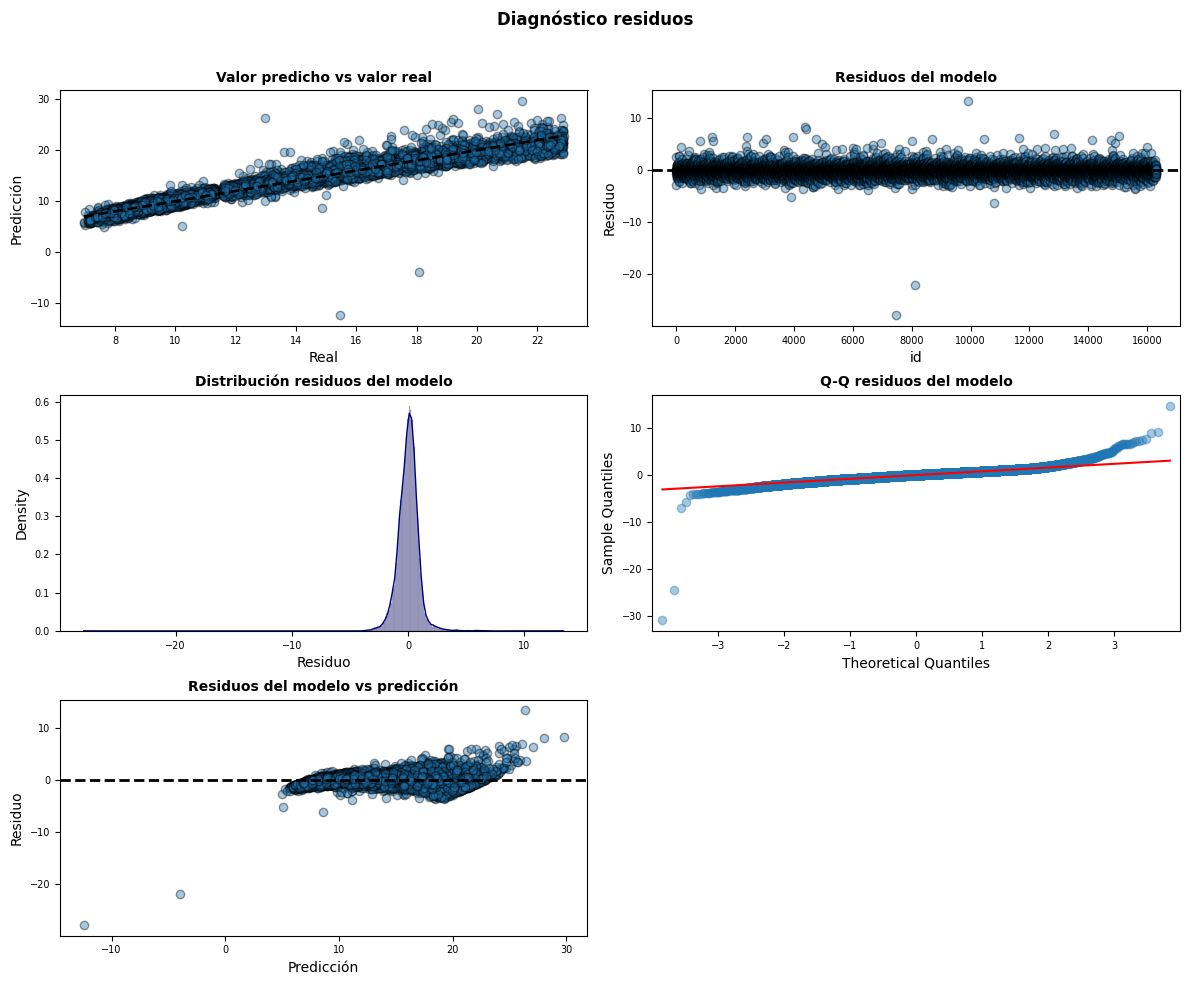

In [ ]:
# Gráficos para el pronóstico de residuos

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   =  "navy",#"firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1],
    color = 'navy', #'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

### Test

In [ ]:
#Se extraen solo las columnas que finalmente quedaron en X_train (excluyendo constante)
X_test = X_test[modelo_X_train.columns[1:len(modelo_X_train)]]

#Adicionamos la constante
X_test = sm.add_constant(X_test)

In [ ]:
# Error de Entrenamiento del modelo


predicciones = modelLRegresion.predict(X_test)

mse = mean_squared_error (y_true  = y_test, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = y_test, y_pred  = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = y_test, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = y_test, y_pred  = predicciones)
r2 = r2_score (y_true  = y_test, y_pred  = predicciones)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

El error MSE   de test es: 0.7181103883704955
El error RMSE  de test es: 0.8474139415719424
El error MAE   de test es: 0.6112352591726292
El error MedAE de test es: 0.4775604377671492
El error R2    de test es: 0.9583956497805799


In [ ]:
X_test

,const,z,cut_Good,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
7816,1.0000,0.8028,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
586,1.0000,0.5148,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
11867,1.0000,0.6824,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
13535,1.0000,0.6265,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
470,1.0000,0.7696,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,1.0000,0.5148,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
16274,1.0000,0.7016,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
17034,1.0000,0.6736,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12197,1.0000,0.7051,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
modelLRegresion.predict(X_test)

7816    20.9066
586      8.2862
11867   17.0444
13535   13.8561
470     20.1344
          ...  
3696    10.4990
16274   16.5526
17034   15.7636
12197   17.5403
16674   10.4984
Length: 4075, dtype: float64

In [ ]:
# Concatenar X_test y y_test
df_prep = pd.DataFrame(np.c_[X_test, y_test], columns= X_test.columns.tolist()+['PriceReal'])
df_prep

,const,z,cut_Good,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,PriceReal
0,1.0000,0.8028,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,22.2331
1,1.0000,0.5148,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,8.4155
2,1.0000,0.6824,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,16.3877
3,1.0000,0.6265,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,13.3607
4,1.0000,0.7696,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,22.6279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4070,1.0000,0.5148,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,10.2914
4071,1.0000,0.7016,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,16.2601
4072,1.0000,0.6736,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.7379
4073,1.0000,0.7051,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,16.4581


In [ ]:
# Predecir los valores para df_prep utilizando el modelLRegresion y Elevar al cubo usando np.power()
resultadoPredict =np.power(modelLRegresion.predict(df_prep.drop(columns ='PriceReal')), 3)
resultadoPredict

0      9137.9559
1       568.9436
2      4951.6009
3      2660.2762
4      8162.3383
          ...   
4070   1157.2981
4071   4535.2159
4072   3917.1366
4073   5396.5195
4074   1157.1049
Length: 4075, dtype: float64

In [ ]:
# Convertir el array numpy resultadoPredic en un DataFrame de pandas
resultadoPredict_df = pd.DataFrame(resultadoPredict, columns=['PricePredict'])
resultadoPredict_df

,PricePredict
0,9137.9559
1,568.9436
2,4951.6009
3,2660.2762
4,8162.3383
...,...
4070,1157.2981
4071,4535.2159
4072,3917.1366
4073,5396.5195


In [ ]:
# Concatenar x_i con el DataFrame de las predicciones
concatenated_df = pd.concat([df_prep.reset_index(drop=True), resultadoPredict_df], axis=1)

# el precio real se eleva al cubo
concatenated_df['PriceReal'] = np.power(concatenated_df['PriceReal'],3)

In [ ]:
concatenated_df['dif'] = (concatenated_df['PriceReal'] - concatenated_df['PricePredict']).abs()


concatenated_df[['PriceReal', 'PricePredict', 'dif']].sort_values(by='dif', ascending=False)

,PriceReal,PricePredict,dif
162,8711.0000,21730.2542,13019.2542
2655,10424.0000,21529.4490,11105.4490
1768,6532.0000,16309.1352,9777.1352
923,6002.0000,14101.4316,8099.4316
235,5993.0000,13726.5457,7733.5457
...,...,...,...
3876,631.0000,631.1767,0.1767
2637,895.0000,895.1594,0.1594
310,9384.0000,9384.1447,0.1447
1798,816.0000,815.9821,0.0179


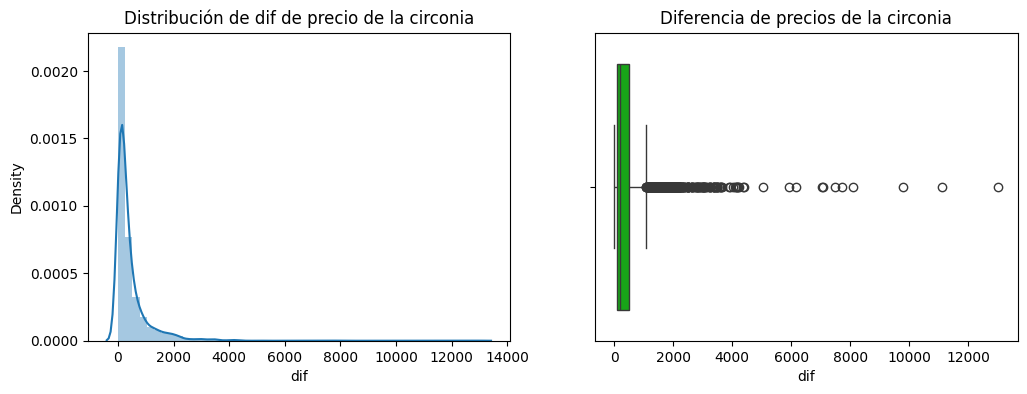

In [ ]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Distribución de dif de precio de la circonia')
sns.distplot(concatenated_df['dif'])

plt.subplot(1,2,2)
plt.title('Diferencia de precios de la circonia')
sns.boxplot(x=concatenated_df['dif'], palette='nipy_spectral')

plt.show()

In [ ]:
print(concatenated_df['dif'].describe())

count    4075.0000
mean      441.4751
std       706.5166
min         0.0179
25%        92.0805
50%       214.7564
75%       493.3442
max     13019.2542
Name: dif, dtype: float64


#### Referencias

- *Regresion Lineal en Python:*
    - https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html
  
  
- *Machine learning con Python y Scikit-learn:*
    - https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
    

- *scikit-learn:*    
    - https://scikit-learn.org/stable/
    - https://scikit-learn.org/stable/user_guide.html
  
  
- *Recursive Feature Elimination (RFE)*:
    - https://www.kaggle.com/goyalshalini93/car-price-prediction-linear-regression-rfe
    - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html


- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180


- *Multicolinealidad:*
    - https://www.analyticslane.com/2020/04/22/solucionar-la-multicolinealidad-con-vif/


- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html